# Financial Sentiment Analysis

In this project I'll get stock news from FinViz and apply sentiment analysis using NLTK's Vaders module (https://www.nltk.org/_modules/nltk/sentiment/vader.html)

In [ ]:
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Imports and Initialization

In [ ]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt

finviz_url = "https://finviz.com/quote.ashx?t="
#tickers = ['AMZN', 'TSLA', 'FB', ]

# getting the S&P 500 companies tickers
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
tickers = df["Symbol"].tolist()

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


## Scraping the FinViz data

In [ ]:
news_tables = {}
for ticker in tickers: 
    url = finviz_url + ticker
    try: 
      req = Request(url=url, headers={'user-agent': 'app'})
      response = urlopen(req)
      html = BeautifulSoup(response, 'html')
      news_table = html.find(id='news-table')
      news_tables[ticker] = news_table
    except: 
      print("No info on ticker: " + ticker)

No info on ticker: BRK.B
No info on ticker: BF.B


In [ ]:
parsed_data = []

for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')

        # date and time sometimes in different formats on website
        if len(date_data) == 1:
            time = date[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

## Creating a DataFrame for visualising the sentiment

In [ ]:
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
headline_df = df

In [ ]:
print(df.head)

<bound method NDFrame.head of       ticker  ...                                              title
0        MMM  ...  3M (MMM) Gains As Market Dips: What You Should...
1        MMM  ...  We need to act with purpose: One 3Mer's passio...
2        MMM  ...  Looking to Generate Passive Income? Consider T...
3        MMM  ...  Why Is 3M (MMM) Down 0.3% Since Last Earnings ...
4        MMM  ...                 Como Welcomes Kulu the Polar Bear!
...      ...  ...                                                ...
50045    ZTS  ...        Top Stock Reports for Apple, Alibaba & AT&T
50046    ZTS  ...  Pfizer (PFE) Gets Unfavorable Votes from FDA P...
50047    ZTS  ...  Novartis (NVS) Posts Positive Data From Prosta...
50048    ZTS  ...               Is Zoetis (ZTS) Stock A Buy or Sell?
50049    ZTS  ...  Zoetis (ZTS) Down 7.5% Since Last Earnings Rep...

[50050 rows x 4 columns]>


## Calling Vader module to get sentiment and integrate it into the DataFrame

In [ ]:
vader = SentimentIntensityAnalyzer()
# only interested in compound score
f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)
df['date'] = pd.to_datetime(df.date).dt.date


In [ ]:
# check how balanced data is
def check_balance(comp_vals):
  pos = (len([x for x in comp_vals if x > 0]) / len(comp_vals)) * 100
  neg = 100 - pos
  print("Positive: " + str(pos) + " Negative: " + str(neg))

check_balance(df["compound"].tolist())

Positive: 41.768231768231765 Negative: 58.231768231768235


## Plot the sentiment of the stocks by each day

In [ ]:
plt.figure(figsize=(10,8))

mean_df = df.groupby(['ticker', 'date']).mean()
print(mean_df.head())

                   compound
ticker date                
A      2021-08-06  0.151725
       2021-08-08  0.000000
       2021-08-09  0.000000
       2021-08-10  0.000000
       2021-08-11  0.202300


<Figure size 720x576 with 0 Axes>

In [ ]:
df_mean = mean_df

In [ ]:
# Skip this step for all S&P 500 comp since it gets messy to see
"""mean_df = mean_df.unstack()
mean_df = mean_df.xs('compound', axis="columns").transpose()
mean_df.plot(kind='bar')"""

'mean_df = mean_df.unstack()\nmean_df = mean_df.xs(\'compound\', axis="columns").transpose()\nmean_df.plot(kind=\'bar\')'

In [ ]:
!pip install yfinance

## Getting stock prices for the tickers

Getting the historical data from yahoo finance. After that the daily returns are calculated and saved in a new data frame

In [ ]:
import yfinance as yf

dates = pd.to_datetime(df_mean.index.get_level_values("date"))
start, end = dates.min().date(), (dates.max() + pd.Timedelta(days=1)).date()
df = (
    yf.download(tickers, start=start, end=end)
      .stack(level=1)
      .drop(columns=["Close", "High", "Low", "Open", "Volume"])
      .rename(columns={"Adj Close": "returns"})
      .reorder_levels([1, 0])
      .sort_index(level=0)
)

df.index = df.index.rename(["ticker", "date"])
df_mean["returns"] = df.returns
df_mean.returns = df_mean.groupby("ticker").returns.pct_change()
df_mean


[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


compound   returns
ticker date                          
A      2021-08-06  0.151725       NaN
       2021-08-08  0.000000  0.000000
       2021-08-09  0.000000  0.005395
       2021-08-10  0.000000 -0.000128
       2021-08-11  0.202300  0.000000
...                     ...       ...
ZTS    2021-11-12  0.202300  0.001247
       2021-11-17  0.585900  0.023150
       2021-11-19  0.000000  0.020553
       2021-11-22  0.381800 -0.009230
       2021-11-30  0.000000 -0.010252

[28026 rows x 2 columns]

## Evaluation

Checking the lagged sentiment score against daily returns using regression. The goal is to see if the sentiment score predicts future stock returns

In [ ]:
# preparing to check older dates comp score with future returns
df_mean["compound_shifted"] = df_mean.compound.shift(1)
df_mean

compound   returns  compound_shifted
ticker date                                            
A      2021-08-06  0.151725       NaN               NaN
       2021-08-08  0.000000  0.000000          0.151725
       2021-08-09  0.000000  0.005395          0.000000
       2021-08-10  0.000000 -0.000128          0.000000
       2021-08-11  0.202300  0.000000          0.000000
...                     ...       ...               ...
ZTS    2021-11-12  0.202300  0.001247          0.000000
       2021-11-17  0.585900  0.023150          0.202300
       2021-11-19  0.000000  0.020553          0.585900
       2021-11-22  0.381800 -0.009230          0.000000
       2021-11-30  0.000000 -0.010252          0.381800

[28026 rows x 3 columns]

In [ ]:
# NaN implies score of 0
df_mean.fillna(0, inplace=True)
df_mean

compound   returns  compound_shifted
ticker date                                            
A      2021-08-06  0.151725  0.000000          0.000000
       2021-08-08  0.000000  0.000000          0.151725
       2021-08-09  0.000000  0.005395          0.000000
       2021-08-10  0.000000 -0.000128          0.000000
       2021-08-11  0.202300  0.000000          0.000000
...                     ...       ...               ...
ZTS    2021-11-12  0.202300  0.001247          0.000000
       2021-11-17  0.585900  0.023150          0.202300
       2021-11-19  0.000000  0.020553          0.585900
       2021-11-22  0.381800 -0.009230          0.000000
       2021-11-30  0.000000 -0.010252          0.381800

[28026 rows x 3 columns]

## Test for predictive value by correlation


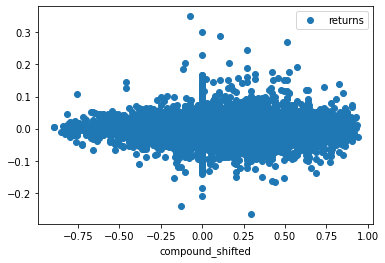

In [ ]:
df_mean.plot(x="compound_shifted", y="returns", style="o")

In [ ]:
df_mean["returns"].corr(df_mean["compound_shifted"])

-0.003154366493376913

## Results and further improvements

As we can see the correlation is close to 0 which means that news headlines alone do no have any predictive value on tomorrows return value. There are improvements which can be made to increase the accuracy.


### 2 second lag and long term relationship

The headlines could be split to 2 types 
- Sensational News 
- Fundamentals-related News


#### Sensational News

This refers to news that causes an instant impact. If we are doing this, we should use news headlines instead of analysis headlines.

Since the news have an instant impact, if we use a 1-day lag for this, it will be too slow.

Thus, we are better off using a shorter time delay such as a 2 second lag. But note that data of such low timeframes are expensive and might not be accurate.

The bad news is, even if you managed to run this analysis significantly accurately, you will be slaughtered by high frequency, or even regular quantitative hedge funds in the real world as you are competing on speed of execution.

#### Fundamentals-related News

This type of news has a longer term fundamental effect.
A 1-day lag might be too short for the effect to kick in.

In this case, we can create a long term index score and add or subtract from it based on the individual article headlines. In addition, since newer headlines might have more impact, we can lower the weightage for older headlines.


### Accuracy of the VADER Sentiment Analyzer

By looking at the output above one can see that the accuracy of VADER is not perfect especially for Finance related news.If we could get a large collection of finance related news we could train our own sentiment analyzer on this specific type of data

### Headlines from other news websites

Currently we have only looked at headline data from FinViz. It might be safer to procure our data from different sources for different purposes.

For sensational news, you would want headlines from the bigger news channels.

For longer term fundamental articles, you might want to procure them from more legitimate blogs or research firms.

In both cases, you will want a mixture from different sources. This will increase objectivity of the data as some sources tend to be biased.

In [ ]:
!pip install transformers


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
  
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")


In [ ]:
#df2 = df.sample(frac=.5)
df2 = headline_df.sample(frac=.01)


inputs = tokenizer(df2["title"].tolist(), padding = True, truncation = True, return_tensors='pt')
print(inputs)

{'input_ids': tensor([[  101,  1031,  2678,  ...,     0,     0,     0],
        [  101,  2054,  1005,  ...,     0,     0,     0],
        [  101,  2642,  3404,  ...,     0,     0,     0],
        ...,
        [  101,  2777, 15509,  ...,     0,     0,     0],
        [  101,  1047,  2721,  ...,     0,     0,     0],
        [  101,  3145,  2155,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [ ]:
outputs = model(**inputs)
print(outputs.logits.shape)


torch.Size([500, 3])


In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions[0]
)

tensor([0.0354, 0.7442, 0.2205], grad_fn=<SelectBackward0>)


In [ ]:
model.config.id2label

#Headline #Positive #Negative #Neutral
positive = predictions[:, 0].tolist()
negative = predictions[:, 1].tolist()
neutral = predictions[:, 2].tolist()

table = {'Headline':df2["title"].tolist(),
         "Positive":positive,
         "Negative":negative, 
         "Neutral":neutral}

In [ ]:
df_finbert = pd.DataFrame(table, columns = ["Headline", "Positive", "Negative", "Neutral"])

df_finbert["compound"] = df_finbert.apply(lambda x: (x["Positive"] - x["Negative"])/2, axis=1)
df_finbert.head()

,Headline,Positive,Negative,Neutral,compound
0,[video]Activision Blizzard Stock: We're Still ...,0.035369,0.744167,0.220464,-0.354399
1,What's in the Offing for Salem Media's (SALM) ...,0.025369,0.369915,0.604716,-0.172273
2,Northern Trust Asset Management Names Chief In...,0.027261,0.028030,0.944709,-0.000384
3,Raytheon (RTX) Arm Wins $737M Deal to Support ...,0.934068,0.013752,0.052180,0.460158
4,"Utility Stock Q2 Earnings Due on Jul 29: XEL, ...",0.026822,0.039680,0.933498,-0.006429
